In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

/export/bbq2/dfm/anaconda3/lib/python3.4/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [11]:
campaign = 1
epicid = "201457244"

# epicid = "201367065"
# epicid = "201912552"
# epicid = "201754305"

# campaign = 3
# epicid = "206475757"

# campaign = 4
# epicid = "211056809"
# epicid = "211028585"

basepath = "/export/bbq2/dfm/k2/web"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    detrend=True,
    invert=True,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    # initial_time=2179.0,
    # initial_time=2264.0,
    skip=0,
    durations=[0.1],
    min_period=1.0,
    max_period=50.,
    npeaks=2,
    mask_frac=1.0,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [12]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True, clobber=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [13]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 0.53s
Querying Likelihood
tau = 2.36474609375
tau = 2.36474609375
tau = 2.36474609375
tau = 2.36474609375
tau = 2.0972900390625
tau = 2.0972900390625
tau = 2.1175537109375
tau = 2.1175537109375
Finished querying Likelihood in 12.30s
Querying OneDSearch
Finished querying OneDSearch in 12.89s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 10.89s
Querying Vetter
Finished querying Vetter in 3.15s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


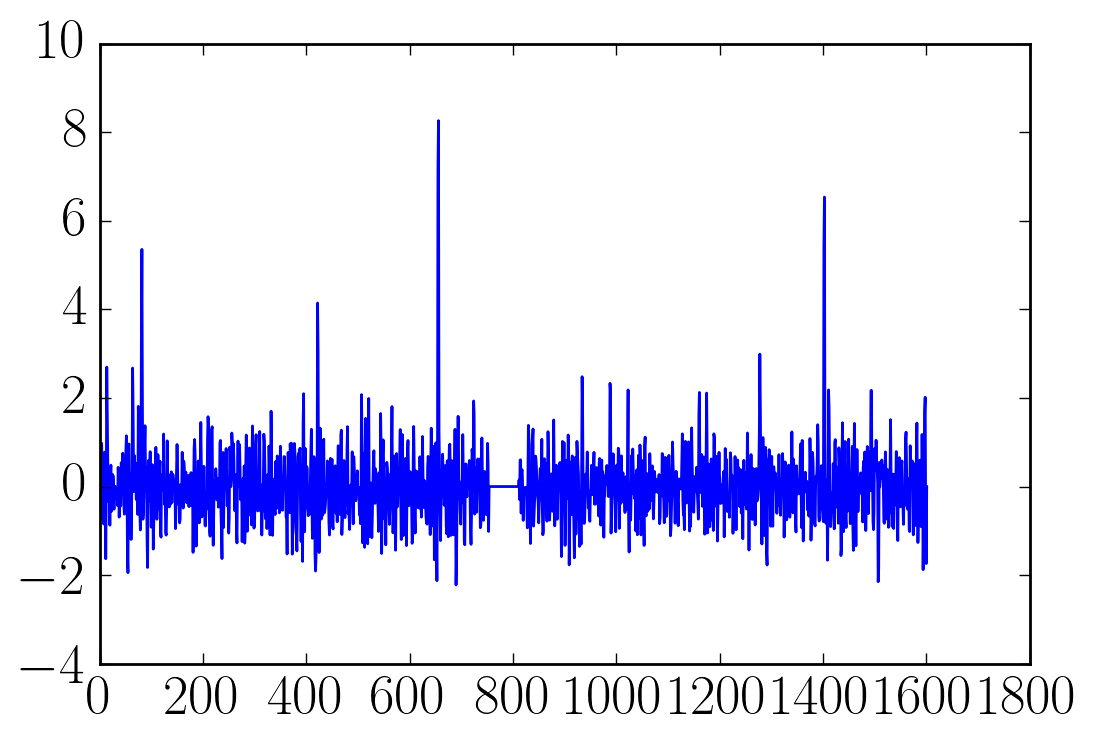

In [14]:
pl.plot(r.depth_1d * np.sqrt(r.depth_ivar_1d))

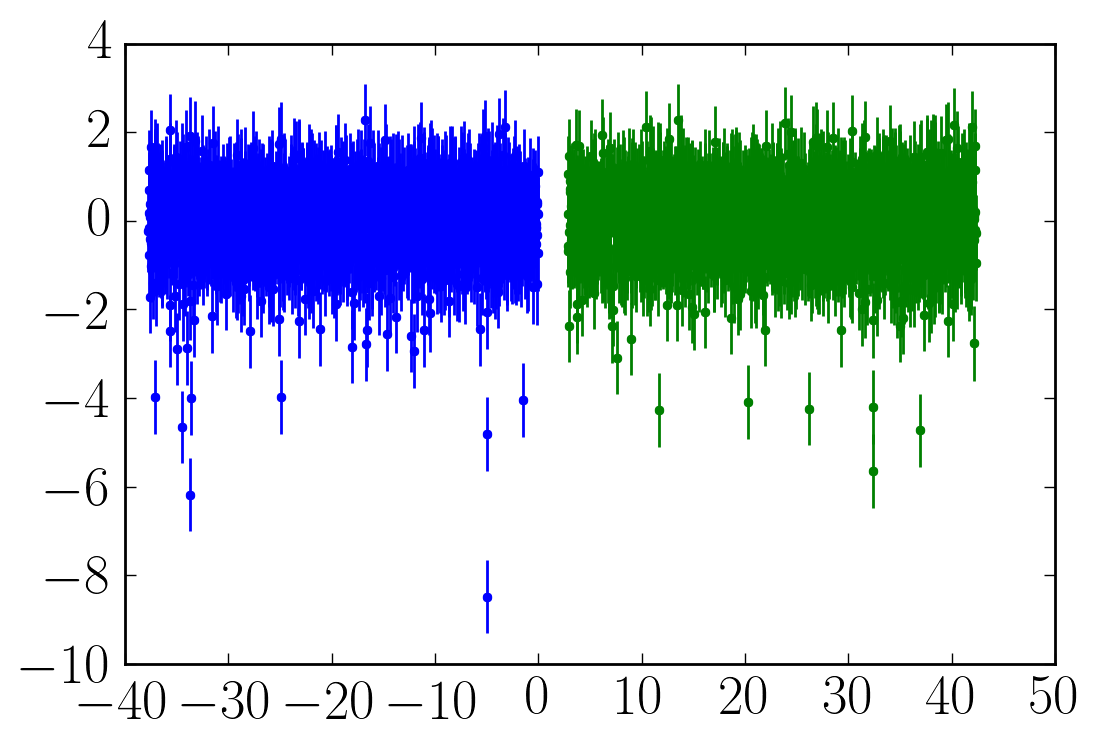

In [15]:
lcs = r.model_light_curves
[pl.errorbar(lc.time, lc.detrend_flux, yerr=lc.detrend_ferr, fmt=".", capsize=0) for lc in lcs];

In [16]:
r.peaks

[{'depth': 2.7598199756916562,
  'depth_ivar': 14.40198945743051,
  'duration': 0.1,
  'lnZ_box': -1866.9451761568221,
  'lnZ_none': -1933.4679057379708,
  'lnZ_outlier': -1866.7295360726625,
  'lnZ_transit': -1855.9104210594869,
  'lnZ_vee': -1870.6452110074401,
  'lnlike_box': -1851.2333180163841,
  'lnlike_none': -1933.4679057379708,
  'lnlike_outlier': -1868.1847906205708,
  'lnlike_transit': -1840.0223749689012,
  'lnlike_vee': -1856.5223120930098,
  'period': 37.32749640700667,
  'phic_same': -1993.1163401874726,
  'phic_same_second': -2007.4178890441356,
  'phic_variable': -3864.4106736694102,
  's2n': 10.473503884014159,
  't0': 32.389703438256944,
  'transit_b': 0.48352245600449761,
  'transit_duration': 0.05962712559550002,
  'transit_period': 37.349126854942803,
  'transit_q1': 0.50616285560628271,
  'transit_q2': 0.50111431645468663,
  'transit_ror': 0.075792758245184236,
  'transit_t0': 32.397741441737033},
 {'depth': 1.549944235110132,
  'depth_ivar': 13.198539069618251,


(-15, 10)

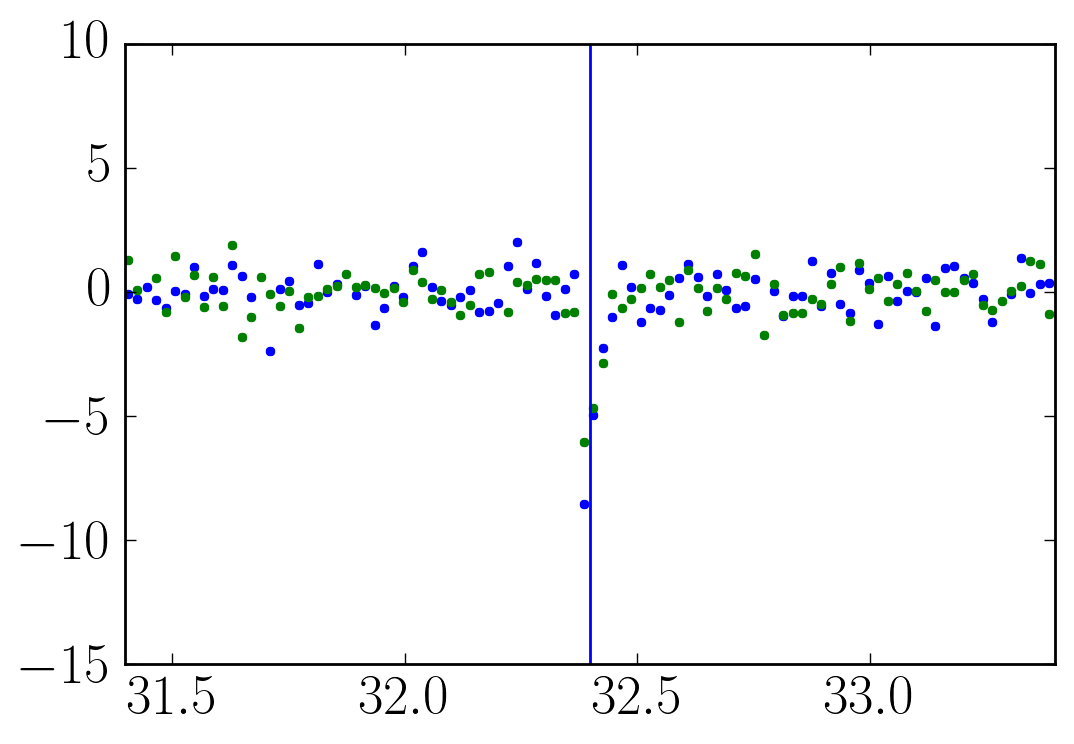

In [19]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

mod = [1e3*(s.light_curve(lc.time)-1.0) for lc in lcs]
[pl.plot(lc.time %  p["transit_period"], lc.flux - lc.predict(lc.flux - m), ".") for lc, m in zip(lcs, mod)]
# [pl.plot(lc.time %  p["transit_period"], m, ".") for lc, m in zip(lcs, mod)]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-1, p["transit_t0"]+1)
pl.ylim(-15, 10)